(dcgan codes written by 류해단)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Load Module

In [0]:
from __future__ import print_function

# from keras.utils.vis_utils import plot_model
# from keras.utils.generic_utils import Progbar

from tensorflow.keras.utils import plot_model, Progbar
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import initializers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Flatten, LeakyReLU, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

from numpy import expand_dims
from tqdm import tqdm

import os
import cv2
import math
import sys
import random
# import warnings

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# os.getcwd()

'/content'

In [15]:
# tf.__version__

'2.2.0-rc4'

In [0]:
#pip install pydot-ng

Note: you may need to restart the kernel to use updated packages.


In [0]:
#pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [0]:
#pip install pydot==1.2.3

  Created wheel for pydot: filename=pydot-1.2.3-py3-none-any.whl size=18931 sha256=719dfeeb0c2cb3db3d6c064767749262f60649e615641978958540bf6e407f81
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\94\a8\4b\d76c975fd000ecff606a1b170d541bbef0f6429fe1084dcb49
Successfully built pydot
Note: you may need to restart the kernel to use updated packages.


## Define Function(DCGAN)

In [0]:
def load_mnist_data():
    """ load mnist data """
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    # X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = (X_train.astype(np.float32)) / 255.0
    # X_test = (X_test.astype(np.float32) - 127.5) / 127.5
    X_test = (X_test.astype(np.float32)) / 255.0

    X_train = X_train[:,:,:,None]
    X_test = X_test[:,:,:,None]

    X_test_original = X_test.copy()

    #X_train = X_train[Y_train==0]
    #X_test = X_test[Y_test==0]
    print('train shape: ', X_train.shape)

    return X_train, X_test, X_test_original, Y_test 

In [0]:
""" build generator model """
def generator_model(z_dim, imgsize, channels): 
    col = int(imgsize / 4)
    inputs = Input((z_dim, ))
    fc1 = Dense(input_dim=z_dim, units=128*col*col)(inputs)
    fc1 = BatchNormalization()(fc1)
    fc1 = LeakyReLU(0.2)(fc1)

    fc2 = Reshape((col, col, 128), input_shape=(128*col*col,))(fc1)
    up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(fc2)
    conv1 = Conv2D(64, (3,3), padding='same')(up1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)

    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1)
    conv2 = Conv2D(channels, (5, 5), padding='same')(up2)
    outputs = Activation('tanh')(conv2)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [0]:
""" build discriminator model """
def discriminator_model(img_size, channels):
    inputs = Input((img_size, img_size, channels))

    conv1 = Conv2D(64, (5,5), padding='same')(inputs)
    conv1 = LeakyReLU(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(128, (5,5), padding='same')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    fc1 = Flatten()(pool2)
    fc1 = Dense(1)(fc1)
    outputs = Activation('sigmoid')(fc1)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [0]:
def generator_containg_discriminator(g, d, z_dim):
    d.trainable = False

    ganInput = Input(shape=(z_dim, ))
    x = g(ganInput)
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)

    return gan

In [0]:
class DCGAN():
    def __init__(self, imgsize, channels, zdims, epoch, batchsize):

        self.img_size = imgsize
        self.channels = channels
        self.z_dim = zdims
        self.epochs = epoch
        self.batch_size = batchsize

        self.d_opt = Adam(lr=1e-5, beta_1=0.1)
        self.g_opt = Adam(lr=2e-4, beta_1=0.5)

        if not os.path.exists('./drive/My Drive/result/'):
            os.makedirs('./drive/My Drive/result/')
        if not os.path.exists('./drive/My Drive/model_images/'):
            os.makedirs('./drive/My Drive/model_images/')

        """ build discriminator model """
        self.d = discriminator_model(self.img_size, self.channels)
        plot_model(self.d, to_file='./drive/My Drive/model_images/discriminator.png', show_shapes=True)

        """ build generator model """
        self.g = generator_model(self.z_dim, self.img_size, self.channels)
        plot_model(self.g, to_file='./drive/My Drive/model_images/generator.png', show_shapes=True)

        """ discriminator on generator model """
        self.d_on_g = generator_containg_discriminator(self.g, self.d, self.z_dim)
        plot_model(self.d_on_g, to_file='./drive/My Drive/model_images/d_on_g.png', show_shapes=True)

        self.g.compile(loss='mse', optimizer=self.g_opt)
        self.d_on_g.compile(loss='mse', optimizer=self.g_opt)
        self.d.trainable = True
        self.d.compile(loss='mse', optimizer=self.d_opt)

    """ plot images for visualization """
    def plot_generate_images(self, gen_images):
        num = gen_images.shape[0]
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
        shape = gen_images.shape[1:4]
        image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                            dtype=gen_images.dtype)
        for index, img in enumerate(gen_images):
            i = int(index/width)
            j = index % width
            image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1], :] = img[:, :, :]
        return image

    """ generate image """
    def generate(self, batch_size):
        self.g.load_weights('./drive/My Drive/saved_model/generator.h5')
        noise = np.random.uniform(0, 1, (batch_size, self.z_dim))
        generate_img = self.g.predict(noise)

        return generate_img

    def train(self, X_train):
        for epoch in range(self.epochs):
            print ("Epoch is ", epoch + 1)
            n_iter = int(X_train.shape[0] / self.batch_size)
            progress_bar = Progbar(target=n_iter)

            for index in range(n_iter):
                # create random noise -> U(0,1) 10 vactors
                noise = np.random.uniform(0, 1, size=(self.batch_size, self.z_dim))

                """ load real data & generate fake data """
                image_batch = X_train[index*self.batch_size:(index+1)*self.batch_size]
                gen_images = self.g.predict(noise, verbose=0)

                # visualize training result
                if index % 50 == 0:
                    image = self.plot_generate_images(gen_images)
                    image =  image*127.5+127.5
                    cv2.imwrite('./result/' + str(epoch)+"_"+str(index)+ ".png", image )

                # attach label for training discriminator
                X = np.concatenate((image_batch, gen_images))
                y = np.array([1] * self.batch_size + [0] * self.batch_size)

                """ training discriminator """
                d_loss = self.d.train_on_batch(X, y)

                """ training generator """
                self.d.trainable = False
                g_loss = self.d_on_g.train_on_batch(noise, np.array([1] * self.batch_size))
                self.d.trainable = True

                progress_bar.update(index, values=[('g', g_loss), ('d', d_loss)])
            print('')

            """ save weights for each epoch """
            if not os.path.exists('./drive/My Drive/saved_model/'):
                os.makedirs('./drive/My Drive/saved_model/')
            self.g.save_weights('./drive/My Drive/saved_model/generator.h5', True)
            self.d.save_weights('./drive/My Drive/saved_model/discriminator.h5',True)

        return self.d, self.g

## Traing DCGAN model

initialize DCGAN 
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
____________________________

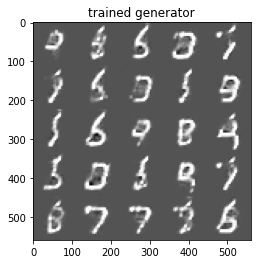

In [9]:
print("initialize DCGAN ")
imgsize = 28
channels = 1
zdims = 100
epoch = 10
batchsize = 64
dcgan = DCGAN(imgsize, channels, zdims, epoch, batchsize)

X_train, X_test, X_test_original, Y_test = load_mnist_data()

print ('============ train on DCGAN ============')
dcgan.train(X_train)

""" test generator """
gen_img = dcgan.generate(25)
img = dcgan.plot_generate_images(gen_img)
img = (img*127.5)+127.5
img = img.astype(np.uint8)
img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)

""" plt view """
plt.figure(num=0, figsize=(4, 4))
plt.title('trained generator')
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

## Save DCGAN model

In [0]:
dcgan.d.save('./drive/My Drive/dcgan.h5')

## Evaluate Discriminator Network in DCGAN model

In [0]:
d_ruined = X_train[:1000].copy()
d_normal = X_train[1000:2000].copy()

In [0]:
d_ruined[:,3,5:15] = 1
d_ruined[:,1:10,5:10] = 1

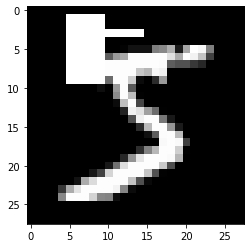

In [13]:
plt.imshow(d_ruined[0].reshape((28,28)), cmap='gray')

In [0]:
d_predicted_normal = dcgan.d.predict(d_normal)
d_predicted_ruined = dcgan.d.predict(d_ruined)

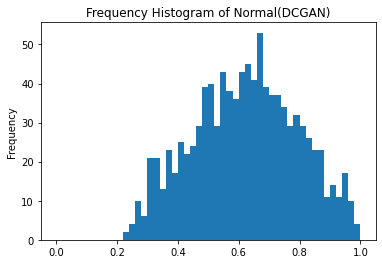

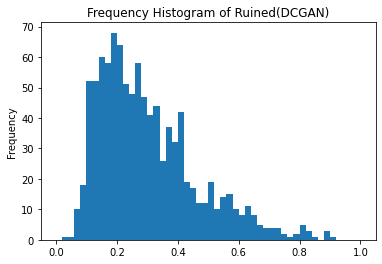

In [17]:
# import matplotlib.pyplot as plt

plt.hist(d_predicted_normal, bins=50, range=(0,1))
plt.gca().set(title='Frequency Histogram of Normal(DCGAN)', ylabel='Frequency');
plt.show()

plt.hist(d_predicted_ruined, bins=50, range=(0,1))
plt.gca().set(title='Frequency Histogram of Ruined(DCGAN)', ylabel='Frequency');


In [18]:
print(d_predicted_normal[:10])

[[0.7672597 ]
 [0.6069737 ]
 [0.6135773 ]
 [0.87042785]
 [0.46993616]
 [0.7274066 ]
 [0.55214757]
 [0.43331382]
 [0.8044417 ]
 [0.7781172 ]]


In [19]:
print(d_predicted_ruined[:10])

[[0.18823954]
 [0.43857   ]
 [0.3566721 ]
 [0.57391614]
 [0.1951774 ]
 [0.280877  ]
 [0.3422764 ]
 [0.22857004]
 [0.33859977]
 [0.22868288]]


## Load MNIST Data and Prepare Inputs for U-Net model

In [0]:
# U-Net


## Before starting
# warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed


# def load_mnist_data():
#     """ load mnist data """
#     (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
#     # X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#     X_train = (X_train.astype(np.float32)) / 255.0
#     # X_test = (X_test.astype(np.float32) - 127.5) / 127.5
#     X_test = (X_test.astype(np.float32)) / 255.0

#     X_train = X_train[:,:,:,None]
#     X_test = X_test[:,:,:,None]

#     X_test_original = X_test.copy()

#     #X_train = X_train[Y_train==0]
#     #X_test = X_test[Y_test==0]
#     print('train shape: ', X_train.shape)

#     return X_train, X_test, X_test_original, Y_test 



## Load MNIST data
# X_train, X_test, X_test_original, Y_test = load_mnist_data()
(x_train, _), (x_test, _) = mnist.load_data()


train = expand_dims(x_train, axis=-1)
test = expand_dims(x_test, axis=-1)

train_ids, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = train.shape  # (60000, 28, 28, 1)
test_ids, _, _, _ = test.shape # (10000, 28, 28, 1)


## Data Normalization (inputs)
train = train.astype('float32')
train = train / 255.0

test = test.astype('float32')
test = test / 255.0

## Prepare inputs(ruined) and outputs(normal) of training data
u_normal = train.copy()

# noise range for ruined
rrn = 5

u_ruined = train.copy()

for i in range(0, u_ruined.shape[0]):
  x = np.random.randint(0, u_ruined.shape[1]-rrn)
  y = np.random.randint(0, u_ruined.shape[1]-rrn)
  z = np.random.randint(0, u_ruined.shape[1]-rrn)
  u_ruined[i, 5:19, x : x+rrn] = 1.
  u_ruined[i, y : y+rrn, 2:10] = 1.
  u_ruined[i, z : z+rrn, z : z+rrn] = 1.

## Prepare inputs(ruined) and outputs(normal) of testing data
u_test_normal = test.copy()

# noise range for test_ruined
trn = 3

u_test_ruined = test.copy()
for i in range(0, u_test_ruined.shape[0]):
  x = np.random.randint(0, u_test_ruined.shape[1]-trn)
  y = np.random.randint(0, u_test_ruined.shape[1]-trn)
  z = np.random.randint(0, u_test_ruined.shape[1]-trn)
  u_test_ruined[i, 5:19, x : x+trn] = 1.
  u_test_ruined[i, y : y+trn, 2:10] = 1.
  u_test_ruined[i, z : z+trn, z : z+trn] = 1.

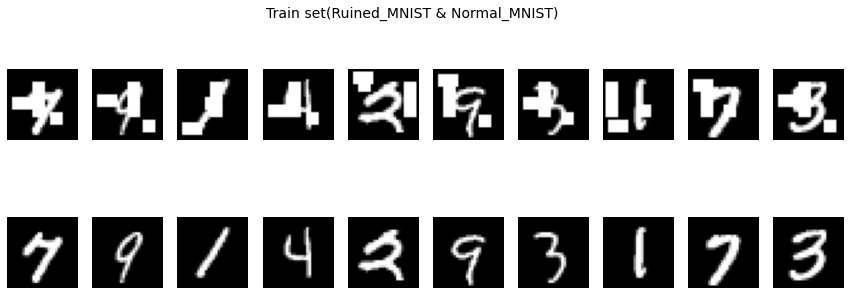

In [29]:
# Check if training data looks all right

fig, axs = plt.subplots(2,10, figsize=(15, 5))
for i in range(10) :
  ix = random.randint(0, train_ids)
  fig.suptitle('Train set(Ruined_MNIST & Normal_MNIST)', fontsize=14)
  axs[0, i].set_axis_off()
  axs[0, i].imshow(u_ruined[ix].reshape(28,28), cmap='gray')
  axs[1, i].set_axis_off()
  axs[1, i].imshow(u_normal[ix].reshape(28,28), cmap='gray')

## Build U-Net model

In [30]:
# Build U-Net model
def unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    s = Lambda(lambda x: x / 255) (inputs)

    # peak 3 (1, 2까지만 maxpooling)
    # 6 - 2
    # 7 - 1
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    
    # peak
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u4)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    
    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c4)
    u5 = concatenate([u5, c1], axis=3)
    c5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
    c5 = Dropout(0.2) (c5)
    c5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c5)
    
    return Model(inputs=[inputs], outputs=[outputs])

u_net = unet()
u_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
u_net.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 28, 28, 1)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 28, 28, 16)   160         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 28, 28, 16)   0           conv2d_26[0][0]                  
____________________________________________________________________________________________

## Train U-Net model

In [31]:
# Fitting

# earlystopper = EarlyStopping(patience=5, verbose=1)
# checkpointer = ModelCheckpoint('model-2020-1.h5', verbose=1, save_best_only=True)
# checkpointer = ModelCheckpoint(filepath = 'model_2020_05.hdf5', verbose=1, save_best_only=True, save_weights_only = True)
# hist = model.fit(ruined, normal, validation_split=0.1, batch_size=10, epochs=50, callbacks=[checkpointer, earlystopper])

hist = u_net.fit(u_ruined, u_normal, validation_split=0.1, batch_size=3, epochs=10)

u_net.save('./drive/My Drive/unet.h5')

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 106s 2ms/sample - loss: 0.0953 - acc: 0.8112 - val_loss: 0.0796 - val_acc: 0.8126
Epoch 2/10
54000/54000 [==============================] - 106s 2ms/sample - loss: 0.0800 - acc: 0.8135 - val_loss: 0.0756 - val_acc: 0.8140
Epoch 3/10
54000/54000 [==============================] - 104s 2ms/sample - loss: 0.0778 - acc: 0.8138 - val_loss: 0.0745 - val_acc: 0.8142
Epoch 4/10
54000/54000 [==============================] - 104s 2ms/sample - loss: 0.0767 - acc: 0.8139 - val_loss: 0.0737 - val_acc: 0.8143
Epoch 5/10
54000/54000 [==============================] - 105s 2ms/sample - loss: 0.0761 - acc: 0.8140 - val_loss: 0.0736 - val_acc: 0.8141
Epoch 6/10
54000/54000 [==============================] - 105s 2ms/sample - loss: 0.0757 - acc: 0.8140 - val_loss: 0.0731 - val_acc: 0.8146
Epoch 7/10
54000/54000 [==============================] - 106s 2ms/sample - loss: 0.0753 - acc: 0.8141 - val_lo

## Visualize test results after training U-Net model

In [32]:
score = u_net.evaluate(u_test_ruined, u_test_normal, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12379400384426117
Test accuracy: 0.79276836


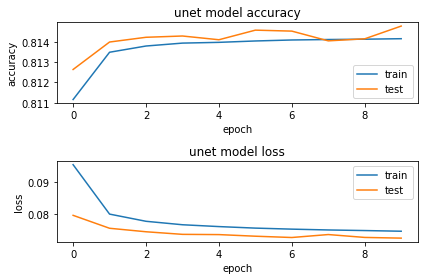

In [34]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('unet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('unet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [0]:
def plotPredictions(model, x_train, y_train, x_test, y_test):
    ix = np.random.randint(0, len(x_train)) ############ <<<

    input_ = x_train[ix:ix+1] ############ <
    mask_ = y_train[ix:ix+1]

    preds_train = model.predict(input_)  ############### <<<<
    preds_train_t = (preds_train > 0.5).astype(np.uint8)  ########### <<<<

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.title("Ruined(U-NET)")
    plt.axis('off')
    plt.imshow(input_[0].reshape((28,28)), 'gray')

    plt.subplot(1,4,2)
    plt.title("Normal(U-NET)")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')

    plt.subplot(1,4,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')  ####### <<<<<<

    # detect residual in train data
    train_residual = input_ - preds_train_t
    train_residual_ = train_residual.reshape((28,28))

    # transformed into 3 channels (RGB)
    train_residual_ = np.stack((train_residual_,)*3, -1)
    rows, cols, channels = train_residual_.shape

    # changing 255 to 0 in first channel
    for i in range(rows): 
        for j in range(cols):
            if train_residual_[i, j, 0] == 1 :
                train_residual_[i, j, 0] = 1

    for i in range(rows):
        for j in range(cols):
            if train_residual_[i, j, 1] == 1 :
                train_residual_[i, j, 1] = 0

    for i in range(rows):
        for j in range(cols):
            if train_residual_[i, j, 2] == 1 :
                train_residual_[i, j, 2] = 0            

    plt.subplot(1,4,4)
    plt.title("Anomaly")
    plt.axis('off')
    plt.imshow(train_residual_)
    plt.show()
    plt.close()

    ix = np.random.randint(0, len(x_test))
    input_ = x_test[ix:ix+1]
    mask_ = y_test[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.title("u_test_ruined")
    plt.axis('off')
    plt.imshow(input_[0].reshape((28,28)), 'gray')

    plt.subplot(1,4,2)
    plt.title("u_test_normal")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')

    plt.subplot(1,4,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')

    # detect residual in test data
    test_residual = input_ - preds_test_t
    test_residual_ = test_residual.reshape((28,28))

    # transformed into 3 channels (RGB)
    test_residual_ = np.stack((test_residual_,)*3, -1)
    rows, cols, channels = test_residual_.shape
    
    # changing 255 to 0 in first channel
    for i in range(rows):
        for j in range(cols):
            if test_residual_[i, j, 0] == 1 :
                test_residual_[i, j, 0] = 1

    for i in range(rows):
        for j in range(cols):
            if test_residual_[i, j, 1] == 1 :
                test_residual_[i, j, 1] = 0

    for i in range(rows):
        for j in range(cols):
            if test_residual_[i, j, 2] == 1 :
                test_residual_[i, j, 2] = 0            

    plt.subplot(1,4,4)
    plt.title("Anomaly")
    plt.axis('off')
    plt.imshow(test_residual_)
    plt.show()
    plt.close()

1/1 [==============================] - 0s 3ms/sample - loss: 0.0282 - acc: 0.9273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


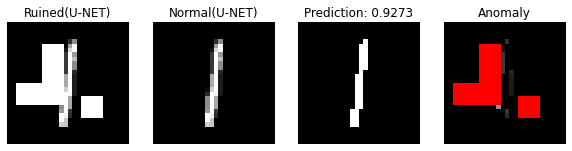

1/1 [==============================] - 0s 2ms/sample - loss: 0.0932 - acc: 0.7666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


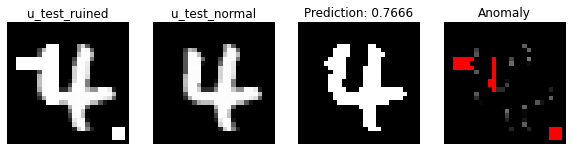

In [39]:
# plot with color
plotPredictions(u_net, u_ruined, u_normal, u_test_ruined, u_test_normal)

## Evaluate U-Net's results with DCGAN's discriminator

In [0]:
ix = np.random.randint(0, len(u_ruined)) ############ <<<
u_input = u_ruined[:ix] ############ <
u_compare = u_normal[:ix]
u_preds_train = u_net.predict(u_input)  ############### <<<<
u_preds_train_t = (u_preds_train > 0.5).astype(np.uint8)  ########### <<<<
# plt.imshow(preds_train_t[0][:,:,0], 'gray')  ####### <<<<<<

u_predicted_normal = dcgan.d.predict(u_compare)
u_predicted_compare = dcgan.d.predict(u_input)
u_predicted_ruined = dcgan.d.predict(u_preds_train_t)

In [0]:
# print(ruined.shape)

(60000, 28, 28, 1)


In [41]:
print(ix)

8630


1/1 [==============================] - 0s 3ms/sample - loss: 0.0964 - acc: 0.7398


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


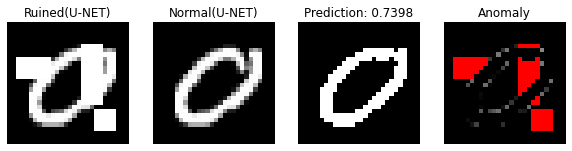

1/1 [==============================] - 0s 2ms/sample - loss: 0.0705 - acc: 0.7819


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


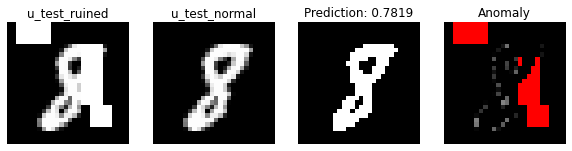

In [42]:
plotPredictions(model, u_ruined, u_normal, u_input, u_compare)

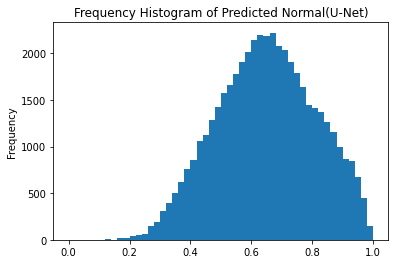

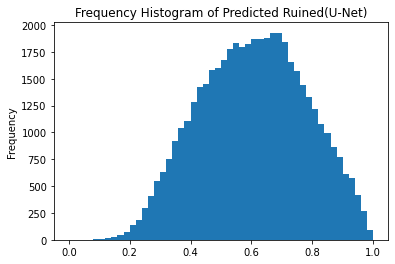

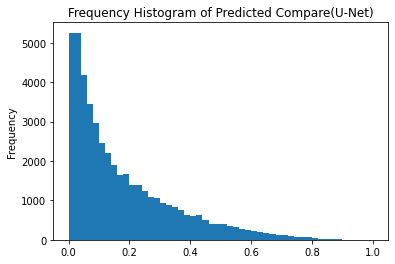

In [48]:
# import matplotlib.pyplot as plt

plt.hist(u_predicted_normal, bins=50, range=(0,1))
plt.gca().set(title='Frequency Histogram of Predicted Normal(U-Net)', ylabel='Frequency');
plt.show()

plt.hist(u_predicted_ruined, bins=50, range=(0,1))
plt.gca().set(title='Frequency Histogram of Predicted Ruined(U-Net)', ylabel='Frequency');
plt.show()


# u_predicted_compare
plt.hist(u_predicted_compare, bins=50, range=(0,1))
plt.gca().set(title='Frequency Histogram of Compare(U-Net)', ylabel='Frequency');
plt.show()

In [44]:
print(u_predicted_normal[:10])

[[0.54268783]
 [0.8571967 ]
 [0.6706413 ]
 [0.8389517 ]
 [0.6476887 ]
 [0.5900427 ]
 [0.66587126]
 [0.612955  ]
 [0.6753938 ]
 [0.63931596]]


In [45]:
print(u_predicted_ruined[:10])

[[0.43471214]
 [0.78109866]
 [0.6248044 ]
 [0.82320607]
 [0.6520396 ]
 [0.54729277]
 [0.7762097 ]
 [0.56405765]
 [0.75611955]
 [0.6329705 ]]
